# **Final Assigment: Yahoo Answers Topic**

# *** Part 3***

---

We house part 3 in separate notebooks. We have one notebook for part A and B, and one notebook for part C and D. This decision was ultimately made due to computational cost concerns. The organization and data pipeline could certainly be improved.

In this part CD notebook, we take our models on the expanded portions of the dataset and then try out some of the techniques that were used in Part 2. Then, we analyze the different methodologies that we incorporated to tie it all together at the end. 

Please note that this CD notebook was executed in Kaggle, while the Part AB notebook was executed in Google Collab. Note that some baseline code from part A that is needed for parts CD are included in this notebook. 

we re-load needed libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_output_dir = "/content/drive/MyDrive/yahoo_models"

In [3]:

# run if colab/kaggle
!pip install -U transformers

!pip install -U datasets fsspec # run this if you run with colab.

!pip install -U datasets evaluate

!pip install nltk
import nltk
nltk.download('stopwords')
!pip install wordcloud

!pip install lime

#!pip install -U scikit-learn
!pip install matplotlib

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from datasets import Dataset
import evaluate
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

In [ ]:
# DO NOT RUN IN KAGGLE
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==1.6.1



Below is where we input our hugging face token. This is how we exported models to our individual hugging face accounts.

I removed my token for this submission

In [ ]:
#from huggingface_hub import login
#login(token="")

We put all of the df preprocessing and loading of the yahoo answers topic into one chunk so that we can run and load it in one go.

We load the train and test sets, input label mapping, conduct some exploratory review of the dataset to confirm its size, and remove empty questions/answers.

In [6]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
label_map = {'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3,
             'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7,
             'Family & Relationships': 8, 'Politics & Government': 9}


# Show basic info
print(f"Dataset size: {len(df)} documents")


# I imported a library that detects the language of the text.
!pip install langdetect
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from collections import defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import pandas as pd


from sklearn.manifold import TSNE
from collections import Counter
import re

from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
from datasets import Dataset, DatasetDict

import string
from transformers import pipeline

empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset size: 1460000 documents
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=c80a4a380b4fd2ad9a5f508361ede7f71a7678352629f7b074f45f10c38f907e
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
Empty questions: 658761
Empty answers: 25606


we verify that we have the dataset intact.

In [ ]:
df.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


Now we load the model from part 2. We take the part 2 model, pre-trained on the small amount of data, as a starting point to proceed.

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load model directly
tokenizer = AutoTokenizer.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")
model = AutoModelForSequenceClassification.from_pretrained("tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2")

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

# Part 3: State of the Art Comparison (2 points)

In this section, we shall benchmark our model against the SOA with the full dataset now available.

## a) Full Dataset Training (0.25 points):
Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.

In [ ]:
# Set model parameters
model_ckpt = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"
num_labels = 10
max_length = 128
batch_size = 32
seed = 42

In [ ]:
#preprocess
df_model = df[['question_content', 'topic']].copy()

df_model = df[['question_content', 'topic']].rename(columns={'topic': 'label'})

df_model.head()

# Convert full dataframe to HF Dataset  (for standard split)
full_dataset = Dataset.from_pandas(df_model).shuffle(seed=seed)

In [ ]:
full_dataset

Dataset({
    features: ['question_content', 'label', '__index_level_0__'],
    num_rows: 785942
})

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["question_content"], padding="max_length", truncation=True, max_length=max_length)

for small percentages we say less than or equal to 25%, we stratify the dataset. We do this to preserve the rough target labeling structure in small sample sizes

We proceed with normal tokenization when the percentage is greater than 25%. With the small dataset sample, we want to still make sure that our trainning and test sets are proportionally representative of the training data (i.e. making sure that we don't have major class imbalances. With the larger proportions of the dataset (i.e. greater than 50%), the model will likely have seen enough of the data that it will be less sensitive to potential class imbalances.

Below, we our model training function will dynamically select the stratified tokenized dataset if the dataset proportion is less than 25%, and select the standard tokenized dataset if not.

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

def stratified_tokenized_split(df_model, pct, seed=42):
    df_sample, _ = train_test_split(df_model, train_size=pct, stratify=df_model["label"], random_state=seed)
    train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["label"], random_state=seed)
    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True)).map(tokenize, batched=True)
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds

def standard_tokenized_split(dataset, pct, seed=42):
    size = int(len(dataset) * pct)
    subset = dataset.select(range(size))
    split = subset.train_test_split(test_size=0.2, seed=seed)
    train_ds = split["train"].map(tokenize, batched=True)
    test_ds = split["test"].map(tokenize, batched=True)
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return train_ds, test_ds

Here is where we implement our model training function and pipeline. It is largely the implementation as what we saw in part 2.

As we mentioned above, training models on this size of data is very computationally costly. Thus, we want to make sure

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall":    recall_score(labels, preds, average="macro"),
    }

# here is the function to train the model
# here is the modified function to train the model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from typing import Optional

def train_model(train_ds, test_ds, pct_label, push_to_hub: bool = False, hub_model_id: Optional[str] = None):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=num_labels,
        problem_type="single_label_classification"
    )

    output_dir = f"/content/drive/MyDrive/yahoo_models_{pct_label}"

    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=20,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        save_total_limit=2,
        seed=seed,
        report_to="none",
        fp16=True,
        dataloader_num_workers=2,
        gradient_accumulation_steps=2,
        push_to_hub=push_to_hub,
        hub_model_id=hub_model_id if push_to_hub else None
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer_output = trainer.train()

    # Always push explicitly if requested
    if push_to_hub:
        trainer.push_to_hub(repo_id=hub_model_id or f"yahoo-model-{pct_label}")
        tokenizer.push_to_hub(repo_id=hub_model_id or f"yahoo-model-{pct_label}")

    return trainer_output, trainer.evaluate(), trainer.state.log_history

# as a precautionary measure, we implement a function to export some descriptive metrics about the model to a csv file
def log_metrics_to_file(pct, metrics, path="/content/drive/MyDrive/yahoo_models/bert_part3_log.txt"):
    with open(path, "a") as f:
        f.write(f"===== {pct}% DATA =====\n")
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n")
        f.write("\n")

To avoid bulk-running the varying model proportions in one for loop, we write a function made for model training, with an input for the desired model proportion. It also has inputs for the stratified and standard tokenized datasets.

## c) Technique Comparison (0.5 points): Incorporate the techniques tested in Part 2 into your training schema for comparison.

Now, we will incorporate the tested techniques from part 2 with the added data. We will try 1 masked token prediction and 2 masked token prediction. We suspect that the synthetic data generation will not lead to the same level of model improvement performance that we observed in part 2, given that we now have much more data available to us.

Due to computational cost concerns, we only run these models on 5% of the dataset.

The Llama 3.2 and synthetic data generation from part 2 were extremely computationally expensive on the limited dataset, and the results were worse than the standard model. One of the Llama 3.2 lines alone took 3 hours to run. Taking this poor performance and computational expense into account, we did not have time to test those approaches in Part 3. We would have been especially interested in using the LLM as a second layer to correct the classification. This remains a potential opportunity for future interest for our group.

### Technique 1: 1 Masked Token Prediction

We try the masked token prediction from part 2. As a reminder, For each sentence in the training set, we randomly select a word to mask. BERT is then used to predict the most likely replacement for the masked word. The resulting sentence is treated as a new augmented example, preserving the original label.  Finally, we combine the original and augmented samples into a new training set and retrain the model. Some major limitations are ungrammatical and context only be preserved locally.

We take 5% of the entire dataset, and then perform stratification to preserve class structure. From that reduced 5% dataset, we perform an 80/20 split on the dataframe.

For this technique, our training data will consist of an even 50-50 split of the true data and the masked data. It would have been nice to test on multiple different proportions of real/augmented data (ex. 75/25, 25/75), but this ultimately was not performed in the end.

In [9]:
df_sample, _ = train_test_split(
    df, train_size=0.05, stratify=df["topic"], random_state=42
)

stratified_train_df, stratified_test_df = train_test_split(
    df_sample,
    test_size=0.2,  # 80/20 split
    stratify=df_sample["topic"],  # match stratify column with the sampled df
    random_state=42
)

Here, we take the augment sentence function we had from part 2 to execute the single masking. Instead, we just see the progress bar and how many sentences were created at the end. 

For each row, three possible augmented sentences are created. We just modify so that we aren't receiving the updates from each single data row. It has some logic to skip sentences that are too small and filter for alphabetic words (w.isalpha()) as tokens. It masks a random word in that phrase, then predicts the masked tokens. 

In [10]:
from tqdm import tqdm

fill_mask = pipeline("fill-mask", model="bert-base-uncased")

# tqdm for progress bar
def augment_sentence(sentence, top_k=3):
    words = sentence.split()
    if len(words) < 3:
        return []

    candidate_indices = [i for i, w in enumerate(words) if w.isalpha()]
    if not candidate_indices:
        return []

    idx = random.choice(candidate_indices)
    words[idx] = '[MASK]'
    masked_sentence = ' '.join(words)

    try:
        predictions = fill_mask(masked_sentence, top_k=top_k)
    except Exception:
        return []

    augmented = []
    for p in predictions:
        filled_sentence = masked_sentence.replace('[MASK]', p['token_str'])
        if filled_sentence.strip() != sentence.strip():
            augmented.append(filled_sentence)
    return augmented


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


we now take the augmented_rows function and create a dataframe of augmented rows

In [11]:
augmented_rows = []
for text, label in tqdm(zip(stratified_train_df["question_content"], stratified_train_df["topic"]),
                        total=len(stratified_train_df), desc="Augmenting"):
    new_sentences = augment_sentence(text, top_k=3)
    for aug in new_sentences:
        augmented_rows.append({
            "question_content": aug,
            "topic": label,
            "source_text": text
        })

# create DataFrame
df_aug = pd.DataFrame(augmented_rows)

Augmenting: 100%|██████████| 31437/31437 [06:57<00:00, 75.31it/s]


Now, let's compare between the real and augmented questions

In [12]:
assert "source_text" in df_aug.columns

comparison_df = df_aug.merge(
    stratified_train_df[["question_content", "topic"]],
    left_on="source_text",
    right_on="question_content",
    suffixes=("_aug", "_real")
)

comparison_df = comparison_df[["question_content_real", "topic_real", "question_content_aug", "topic_aug"]]
comparison_df.columns = ["real_question", "real_topic", "augmented_question", "augmented_topic"]

pd.set_option("display.max_colwidth", None)
display(comparison_df.sample(10, random_state=42))

,real_question,real_topic,augmented_question,augmented_topic
6271,"I have Spy Sweeper, Ad-Aware SE Personal, and Norton Anti-Virus 2005 and they don't seem to do the job. There's still one or two programs running on here when I use all three and sometimes I'll have to manually delete them myself. Please help!",4,"I have Spy Sweeper, Ad-Aware SE Personal, and Norton Anti-Virus 2005 and they don't seem to do the job. There's still one of two programs running on here when I use all three and sometimes I'll have to manually delete them myself. Please help!",4
23121,"I have a really good friend who really likes a girl. I've been trying to help him with this girl, and he confides in me about her. Now i like her too, but my friend likes her and has been sharing all his feelings for her with me. Its messed up to go for her, but then again, if he was my friend wouldn't he understand? why should 2 people be sad without eachother for one person? Then agaaaain, hes my best friend and i'd be betraying him. Talking to him would just upset him, but just letting go of her would tear me upp! what is the best move here?",8,"I have a really good friend who really likes a girl. I've been trying to help him with this girl, and he confides in me about her. so i like her too, but my friend likes her and has been sharing all his feelings for her with me. Its messed up to go for her, but then again, if he was my friend wouldn't he understand? why should 2 people be sad without eachother for one person? Then agaaaain, hes my best friend and i'd be betraying him. Talking to him would just upset him, but just letting go of her would tear me upp! what is the best move here?",8
9769,My husband and I are trying to reconcile but I think he has a hidden agenda. I left my husband a year ago for putting me down all the time & my childern were also told by him they would be losers.But since the death of his youngest child he seems to change but I'm unsure it seems to me that he wants me to fight (fist fight) the other woman who he has been with the year I was gone. I told him the only way that would happen is if she smacked me in the face and It wouldn't be over him it would be only to save me. So I guess I'm wondering should I even bother reconciling with a this man even though I love him?,8,My husband and I are trying to reconcile but I think he has a hidden agenda. I left my husband a year ago for putting me down all the time & my childern were also told by him they would be losers.But since the death of his youngest child he seems to change but I'm unsure it seems to me that he wants me to fight (fist fight) the other woman who he has been with the year I was gone. I told him the only way that would happen is if she smacked me in my face and It wouldn't be over him it would be only to save me. So I guess I'm wondering should I even bother reconciling with a this man even though I love him?,8
3855,this is to settle a bet i say he did my friend says he didnt,5,this is to settle a bet i say he did my friend but he didnt,5
39452,Is there a utility program that will tell me if my boss is looking at my screen when I'm at work?\n\nWindowsXP Pro OS.\n\nThanks.,4,Is there a utility program that will tell me if my boss was looking at my screen when I'm at work?\n\nWindowsXP Pro OS.\n\nThanks.,4
74851,"""he/she was injured"" is what i need to say. so i need the preterate form of doler for he/she was. past tence, he/she was, doler.",3,"""he/she was injured"" is everything i need to say. so i need the preterate form of doler for he/she was. past tence, he/she was, doler.",3
11744,"I have never used it, but am starting to see it everywhere. I guess I just don't know where to start.",4,"I have never used it, but am starting to see them everywhere. I guess I just don't know where to start.",4
35089,"Problem: A construction crew must build a road in 10 months or they will be penalized $500,000. It took 10 workers 6 months to build half of the road. How many additional worker

Note that this table is not designed as well as we saw in Part 2, as the table in Part 2 had a flag for where in the sentence the mask was located. It's difficult to see the mask here, esepecially for the longer questions.

We can see from one of the examples...

| Original Question                                            | Augmented Question                                          |
|--------------------------------------------------------------|--------------------------------------------------------------|
| this is to settle a bet i say he did my friend [MASK] says he didnt | this is to settle a bet i say he did my friend [MASK] but he didnt |

That we are correctly observing masking of one token in the string.

Here, we implement the 50/50 split of the real and augmented data. We set the augmented dataset to the same length of the real stratified dataset.

In [ ]:
# Downsample augmented data to match real train size
df_aug_sample = df_aug.sample(n=len(stratified_train_df), random_state=42).reset_index(drop=True)

# Concatenate real and augmented data for training
train_final_df = pd.concat([stratified_train_df, df_aug_sample], ignore_index=True)

#Use test_real_df as final test set
test_final_df = stratified_test_df.copy()

# Results
print(f"real set shape: {stratified_train_df.shape} (real)")
print(f"augmented set shape: {df_aug_sample.shape} (augmented)")

print(f"Train set shape: {train_final_df.shape} (real + augmented)")
print(f"Test set shape: {test_final_df.shape} (all real)")

real set shape: (31437, 5) (real)
augmented set shape: (31437, 3) (augmented)
Train set shape: (62874, 6) (real + augmented)
Test set shape: (7860, 5) (all real)


A limitation of this approach is that we now technically do not have a true 80/20 split on our training test data. We added more training data. A smarter approach would have been to maintain the size of the training set, but replace half of the values with the augmented masked data. Instead, we have an 88/12 split.

This was an oversight and an error which should have been caught earlier. This could have contributed to the overfitting that we observe below, with the model struggling to generalize on unseen data. 

In [14]:
# Create label2id mapping based on full dataset
label2id = {label: idx for idx, label in enumerate(sorted(df["topic"].unique()))}

# Apply to test set
test_final_df["label"] = test_final_df["topic"].map(label2id)

# Apply to both augmented training sets
train_final_df["label"] = train_final_df["topic"].map(label2id)

We set up the dataframes for modeling. We convert the dataframes to huggingface datasets and tokenize.

In [ ]:
from datasets import Dataset

def tokenize(batch):
    return tokenizer(batch["question_content"], padding="max_length", truncation=True, max_length=128)


# Balanced version
ds_train_balanced = Dataset.from_pandas(train_final_df[["question_content", "label"]])
ds_train_balanced = ds_train_balanced.map(tokenize, batched=True)
ds_train_balanced.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Test set (unchanged)
ds_test = Dataset.from_pandas(test_final_df[["question_content", "label"]])
ds_test = ds_test.map(tokenize, batched=True)
ds_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/62874 [00:00<?, ? examples/s]

Map:   0%|          | 0/7860 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall":    recall_score(labels, preds, average="macro"),
    }

# Setup training config
model_ckpt = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"
num_labels = len(label2id)
batch_size = 64
seed = 42
pct_label = "05_multi_mask"
hub_model_id = "tirdodbehbehani/yahoo-bert-05_balanced_1_mask_aug"
output_dir = f"/content/drive/MyDrive/yahoo_models_{pct_label}"

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    seed=seed,
    report_to="none",
    fp16=True,
    dataloader_num_workers=2,
    gradient_accumulation_steps=2,
    push_to_hub=True,
    hub_model_id=hub_model_id
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train_balanced,
    eval_dataset=ds_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_output = trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.202000,1.036039,0.672010,0.672960,0.668298
2,0.763700,1.120070,0.664504,0.667700,0.658740
3,0.530800,1.224458,0.659288,0.653803,0.655769
4,0.355400,1.396739,0.646438,0.651400,0.642057


TypeError: Trainer.create_model_card() got an unexpected keyword argument 'repo_id'

We're seeing severe overfiting. Training loss is decreasing and validation loss is increasing, with both rates of change moving at a rapid rate.

The best results obtained using this method show an accuracy of 0.672, with a precision of 0.673 and a recall of 0.668. These values indicate a reasonably balanced performance, suggesting that the model is making correct predictions at a consistent rate and is able to retrieve a good proportion of the relevant instances.

To better understand how the model behaves across different topics, we will analyze its performance at a more detailed level. For this purpose, we will generate a confusion matrix and a classification report.

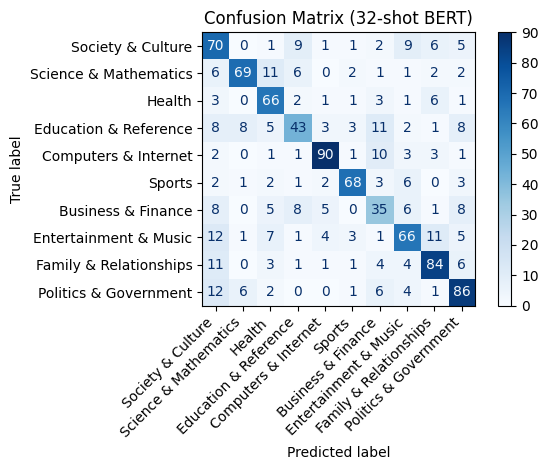

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = ds_test.select(range(1000))

#training_args = TrainingArguments(
#    output_dir="./results",
##    report_to="none" )

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=args
)

# Get predictions
preds = trainer.predict(small_eval)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
class_names = train_dataset.features['topic'].names
label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.xticks(fontsize=10, ha='right')  # horizontal alignment
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

                        precision    recall  f1-score   support

     Society & Culture       0.52      0.67      0.59       104
 Science & Mathematics       0.81      0.69      0.75       100
                Health       0.64      0.79      0.71        84
 Education & Reference       0.60      0.47      0.52        92
  Computers & Internet       0.84      0.80      0.82       112
                Sports       0.84      0.77      0.80        88
    Business & Finance       0.46      0.46      0.46        76
 Entertainment & Music       0.65      0.59      0.62       111
Family & Relationships       0.73      0.73      0.73       115
 Politics & Government       0.69      0.73      0.71       118

              accuracy                           0.68      1000
             macro avg       0.68      0.67      0.67      1000
          weighted avg       0.68      0.68      0.68      1000



 The model performs particularly well in categories like Computers & Internet, Science & Mathematics, and Sports, where both precision and recall are above 0.75. In contrast, categories such as Business & Finance and Education & Reference show weaker performance, especially in recall, indicating that the model struggles to correctly identify instances in these classes. This suggests that while the model is generally effective, its performance varies notably across topics, likely due to overlapping semantic content between certain categories.

In [ ]:

# Push model and tokenizer to Hugging Face
trainer.push_to_hub(hub_model_id)
tokenizer.push_to_hub(hub_model_id)

# Save eval metrics to file (optional)
def log_metrics_to_file(pct, metrics, path="/content/drive/MyDrive/yahoo_models_05_multi_mask/bert_part3_log.txt"):
    with open(path, "a") as f:
        f.write(f"===== {pct}% DATA =====\n")
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n")
        f.write("\n")

metrics = trainer.evaluate()
log_metrics_to_file(pct_label, metrics)

Uploading...:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Let's look at the quality of the augmented samples for a data audit and sanity check.

In [ ]:
import pandas as pd

# Display a random sample of original vs. augmented examples (side-by-side)
def show_augmented_examples(df_aug, n=10):
    sample = df_aug.sample(n=n, random_state=42)
    for i, row in sample.iterrows():
        print(f"--- Topic: {row['topic']} ---\n")
        print(f"Original : {row['source_text']}")
        print(f"Augmented: {row['question_content']}\n")

# Inspect 10 random examples
show_augmented_examples(df_aug, n=10)

--- Topic: 3 ---

Original : Its a song sung by a band called Incubus. but i need to know what it really means.
Augmented: Its a song sung by a band called Incubus. but i need to understand what it really means.

--- Topic: 6 ---

Original : Do gyz like the girly-girlz with the high skirts and lots of make-up, or sporty girlz who plays spots just as good as they do?
Augmented: Do gyz like the girly-girlz with the high skirts and layers of make-up, or sporty girlz who plays spots just as good as they do?

--- Topic: 6 ---

Original : What would some examples be? what kind of organizations would hire a credit manager and what would they do?
Augmented: What would some examples be? what kind of organizations would hire a credit manager and why would they do?

--- Topic: 3 ---

Original : pls answer this queation with a good explanation\n\nWILL WAR SOLVE ANY PROBLEMS???
Augmented: pls answer this question with a good explanation\n\nWILL WAR SOLVE ANY PROBLEMS???

--- Topic: 4 ---

Original 

We can see that the augmente sentences are really bad. The masks aren't very good, we're losing meaning. Additionally, notice how we have this example:

--

--- Topic: 0 ---

Original : He enjoys hunting & sports. Isn't a business kind of man. Very macho.
Augmented: He enjoys hunting & sports. Isn't a bad kind of man. Very macho.

--

Switching from "business" to "bad" loses the meaning behind the original sentence. The topic has changed from a business to social topic, while keeping the label the same. Evidently, the model is going to have a tough time on unseen data with this type of change.

We'll try the multi-mask model, and try to make some tweaks to improve the masking.

I ran the below model earlier, but lost the model parameters when my kaggle editor crashed. I was unable to save the model parameters prior to the crash. We tried re-creating the model output of 0.75 accuracy, but were ultimately unable to do so. Because of this, we don't reference this model when we discuss our best performing models or elsewhere in the report. My hypothesis is that the improved performance was a result of tweaking the augmented sentece function. I tweaked with this function over numerous model runs and was unable to pinpoint what exactly had happened.

However, I am including a screenshot of the per-epoch model iterations below.

In [ ]:
#model_ckpt = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"
#num_labels = len(label2id)
#batch_size = 100                  # or 32 / 64 if you want faster iterations
#seed = 42

# Balanced training version
# metrics_balanced = train_model(ds_train_balanced, ds_test, pct_label="05_balanced_aug")
# log_metrics_to_file("05_balanced_aug", metrics_balanced)

NameError: name 'train_model' is not defined

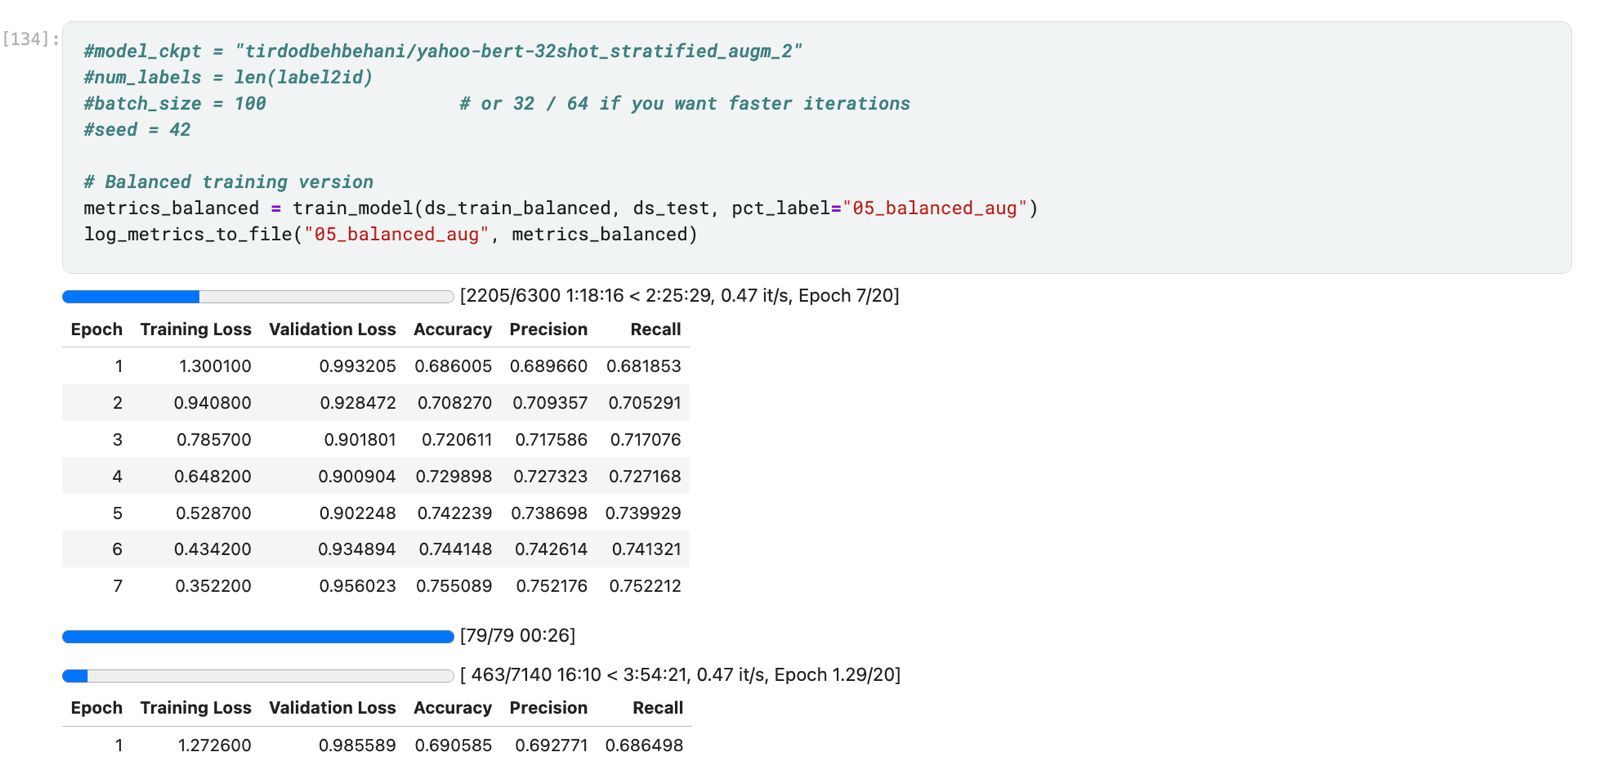

### Technique 2: 2 Masked Token Prediction

Now that we have done the 1 masked token prediction, we move onto the two masked token prediction. We would have done 3 masked token prediction to match what we had in part 2, but the augment_sentence_multi_mask() function was very computationally costly on the enlarged dataset.

In [31]:
from sklearn.model_selection import train_test_split

df_sample, _ = train_test_split(
    df, train_size=0.05, stratify=df["topic"], random_state=42
)

train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,  # 80/20 split
    stratify=df_sample["topic"],
)

In [32]:
from itertools import product
from transformers import pipeline

fill_mask = pipeline("fill-mask", model="bert-base-uncased", device=0)

# Augmentation with 2 masked tokens
def augment_sentence_multi_mask(sentence, top_k=2, num_masks=2):
    words = sentence.split()
    if len(words) < num_masks + 1:
        return []

    candidate_indices = [i for i, w in enumerate(words) if w.isalpha()]
    if len(candidate_indices) < num_masks:
        return []

    mask_indices = random.sample(candidate_indices, num_masks)
    mask_indices.sort()  # important for stable replacement
    mask_tokens = [f"[MASK{i+1}]" for i in range(num_masks)]

    # Apply custom masks at fixed positions
    masked_words = words.copy()
    for idx, mask in zip(mask_indices, mask_tokens):
        masked_words[idx] = mask

    masked_sentence = ' '.join(masked_words)

    filled = {}
    for mask_token in mask_tokens:
        single_masked = ' '.join(
            w if w != mask_token else '[MASK]' for w in masked_words
        )
        try:
            preds = fill_mask(single_masked, top_k=top_k)
            filled[mask_token] = [p["token_str"] for p in preds]
        except:
            return []

    augmented = []
    for combo in product(*filled.values()):
        augmented_words = masked_words.copy()
        for token, replacement in zip(mask_tokens, combo):
            for i, word in enumerate(augmented_words):
                if word == token:
                    augmented_words[i] = replacement
                    break
        filled_sentence = ' '.join(augmented_words)
        if filled_sentence.strip() != sentence.strip():
            augmented.append(filled_sentence)

    return augmented

# Apply augmentation
augmented_rows = []
for text, label in tqdm(zip(train_df["question_content"], train_df["topic"]), total=len(train_df)):
    augmented_sents = augment_sentence_multi_mask(text, top_k=2, num_masks=2)
    for aug in augmented_sents:
        augmented_rows.append({"question_content": aug, "topic": label})

# Create dataframe
df_aug = pd.DataFrame(augmented_rows)
print(f"\n2-Mask Augmentation complete: {len(df_aug)} new examples generated.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
100%|██████████| 31437/31437 [16:02<00:00, 32.66it/s]



2-Mask Augmentation complete: 114794 new examples generated.


We input a sample sentence to observe how the 2 token masking works.

In [33]:
augment_sentence_multi_mask("How can I increase my credit score fast?")

['How can I get my credit so fast?',
 'How can I get my credit card fast?',
 'How can I make my credit so fast?',
 'How can I make my credit card fast?']

"Increase" and "Score" are the two masked words. They are replaced with "get/make" or "so/card".

Now that we have the multi-masking code implemented, we can just repeat the same code to prepare the masked sentences for the model.

In [34]:
# Downsample augmented data to match real train size
df_aug_sample = df_aug.sample(n=len(train_df), random_state=42).reset_index(drop=True)

# Concatenate real and augmented data for training
train_final_df = pd.concat([train_df, df_aug_sample], ignore_index=True)

# Use test_real_df as final test set
test_final_df = test_df.copy()

# Results
print(f"real set shape: {train_df.shape} (real)")
print(f"augmented set shape: {df_aug_sample.shape} (augmented)")

print(f"Train set shape: {train_final_df.shape} (real + augmented)")
print(f"Test set shape: {test_final_df.shape} (all real)")

real set shape: (31437, 5) (real)
augmented set shape: (31437, 2) (augmented)
Train set shape: (62874, 5) (real + augmented)
Test set shape: (7860, 5) (all real)


In [35]:
# Create label2id mapping based on full dataset
label2id = {label: idx for idx, label in enumerate(sorted(df["topic"].unique()))}

# Apply to test set
test_final_df["label"] = test_final_df["topic"].map(label2id)

# Apply to both augmented training sets
train_final_df["label"] = train_final_df["topic"].map(label2id)

In [ ]:
from datasets import Dataset

def tokenize(batch):
    return tokenizer(batch["question_content"], padding="max_length", truncation=True, max_length=128)

# Convert to datasets and tokenize

# Balanced version
ds_train_balanced = Dataset.from_pandas(train_final_df[["question_content", "label"]])
ds_train_balanced = ds_train_balanced.map(tokenize, batched=True)
ds_train_balanced.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Test set (unchanged)
ds_test = Dataset.from_pandas(test_final_df[["question_content", "label"]])
ds_test = ds_test.map(tokenize, batched=True)
ds_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/62874 [00:00<?, ? examples/s]

Map:   0%|          | 0/7860 [00:00<?, ? examples/s]

In [ ]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall":    recall_score(labels, preds, average="macro"),
    }

# Setup training config
num_labels = len(label2id)
batch_size = 64
seed = 42
pct_label = "05_multi_mask"
hub_model_id = "tirdodbehbehani/yahoo-bert-05_balanced_2_mask_aug"
output_dir = f"/content/drive/MyDrive/yahoo_models_{pct_label}"

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    seed=seed,
    report_to="none",
    fp16=True,
    dataloader_num_workers=2,
    gradient_accumulation_steps=2,
    push_to_hub=True,
    hub_model_id=hub_model_id
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train_balanced,
    eval_dataset=ds_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_output = trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.226000,1.035902,0.669211,0.673733,0.665669
2,0.791800,1.090905,0.665522,0.665416,0.659518
3,0.558900,1.207563,0.660305,0.655504,0.655658
4,0.387900,1.339371,0.648982,0.653089,0.645135


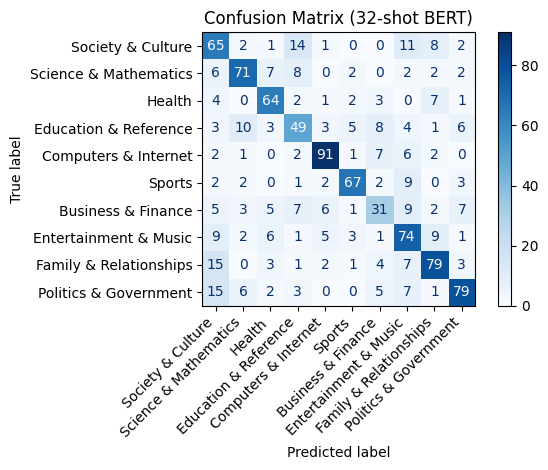

In [37]:
tokenizer = AutoTokenizer.from_pretrained("tirdodbehbehani/yahoo-bert-05_balanced_2_mask_aug")
model = AutoModelForSequenceClassification.from_pretrained("tirdodbehbehani/yahoo-bert-05_balanced_2_mask_aug")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = ds_test.select(range(1000))

# training_args = TrainingArguments(
#     output_dir="./results",
#     report_to="none" )

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args
)

# Get predictions
preds = trainer.predict(small_eval)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

class_names = train_dataset.features['topic'].names
label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.xticks(fontsize=10, ha='right')  # horizontal alignment
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

                        precision    recall  f1-score   support

     Society & Culture       0.52      0.62      0.57       104
 Science & Mathematics       0.73      0.71      0.72       100
                Health       0.70      0.76      0.73        84
 Education & Reference       0.56      0.53      0.54        92
  Computers & Internet       0.82      0.81      0.82       112
                Sports       0.82      0.76      0.79        88
    Business & Finance       0.51      0.41      0.45        76
 Entertainment & Music       0.57      0.67      0.62       111
Family & Relationships       0.71      0.69      0.70       115
 Politics & Government       0.76      0.67      0.71       118

              accuracy                           0.67      1000
             macro avg       0.67      0.66      0.66      1000
          weighted avg       0.67      0.67      0.67      1000



The classification report for the BERT model trained with data augmentation using 3-token masking shows an overall accuracy of 67%. The best-performing categories include Computers & Internet, Health, and Science & Mathematics, all showing strong precision and recall. On the other hand, classes like Business & Finance and Education & Reference show comparatively weaker results, especially in recall, suggesting the model struggles to consistently identify instances from these categories.

When comparing these results to the model trained with 1-token masking, we observe very similar overall results. Performance differences across specific categories are generally marginal, although the 1-token masking model achieved slightly better precision and recall in categories such as Politics & Government and Science & Mathematics. Conversely, the 3-token masking model slightly outperformed in Health and Entertainment & Music.

These small fluctuations suggest that increasing the number of masked tokens in this context does not lead to consistent or meaningful improvements in classification performance. The results align with the expectation that such augmentation techniques may offer limited benefit when the model already performs near its capacity with the available data.

In [ ]:
# Push model and tokenizer to Hugging Face
trainer.push_to_hub(hub_model_id)
tokenizer.push_to_hub(hub_model_id)

# Save eval metrics to file (optional)
def log_metrics_to_file(pct, metrics, path="/content/drive/MyDrive/yahoo_models_05_multi_mask/bert_part3_log2.txt"):
    with open(path, "a") as f:
        f.write(f"===== {pct}% DATA =====\n")
        for k, v in metrics.items():
            f.write(f"{k}: {v:.4f}\n")
        f.write("\n")

metrics = trainer.evaluate()
log_metrics_to_file(pct_label, metrics)

Uploading...:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Using the techniques from part 2 of dataset augmentation. token masking — we observe that the results are essentially the same as those obtained without data augmentation. This outcome is expected, given that the model is trained on only about 5% of the full dataset (approximately 40,000 samples). The augmented data generated through these techniques does not provide any additional meaningful information that could improve the model's performance. This suggests that the model is already learning all it can from the limited data available, and that the masked versions do not introduce new patterns or variability that enhance generalization. The controlled noise from the masking is having minimal impact on the model's ability to generalize on unseen data, which is an unfortanate development.



These results are consistent with those obtained in section 3.a, where we trained the model with 10% and 25% of the dataset. Performance did not improve significantly, indicating that the model does not require large quantities of data to learn effectively. However, increasing the amount of training data led to a substantial rise in computational cost, making it infeasible to train the model on more than 25% of the dataset. The number of hours required would have exhausted our available GPU resources, preventing us from completing the remaining practical tasks.

## d) Methodology Analysis (1 point): Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.

PLEASE NOTE: Due to time constraints and code environmment issues, we did not have sufficient time to add more code-based analysis in this section. Given those limitations, we will discuss what we had.

As a refresher, here was the SOA that we found in Part 1:

| Rank | Model             | Accuracy (%) | Paper Title                                                                 | Year |
|------|-------------------|--------------|------------------------------------------------------------------------------|------|
| 1    | BERT-ITPT-FiT     | 77.62        | How to Fine-Tune BERT for Text Classification?                              | 2019 |
| 2    | DRNN              | 76.26        | Disconnected Recurrent Neural Networks for Text Categorization              | 2018 |
| 3    | DELTA (HAN)       | 75.10        | DELTA: A DEep learning based Language Technology plAtform                   | 2019 |
| 4    | EXAM              | 74.80        | Explicit Interaction Model towards Text Classification                      | 2018 |
| 5    | DNC+CUW           | 74.30        | Learning to Remember More with Less Memorization                            | 2019 |
| 6    | ULMFiT (Small data)| 74.30       | Sampling Bias in Deep Active Classification: An Empirical Study             | 2019 |
| 7    | CCCapsNet         | 73.85        | Compositional Coding Capsule Network with K-Means Routing for Text Classification | 2018 |
| 8    | SWEM-concat       | 73.53        | Baseline Needs More Love: On Simple Word-Embedding-Based Models and Associated Pooling Mechanisms | 2018 |
| 9    | FastText          | 72.30        | Bag of Tricks for Efficient Text Classification                             | 2016 |
| 10   | Seq2CNN (50)      | 55.39        | Abstractive Text Classification Using Sequence-to-convolution Neural Networks | 2018 |


And now a quick recap of our models and their accuracies:
- Part 1:
    - Random Classifier Performance: Accuracy = 9.99%
    - Baseline Implementation = 21.25%

- Part 2:
    - BERT Model with Limited Data: 
        - 32 shot 1.0 (no class balancing): 13.1%
        - 32 shot 2.0 (class balancing): 13.6%
    - Dataset Augmentation
        - 1 Masked Token Prediction: 11.1%
        - 3 Masked Token Prediction: 14.4%
    - Zero Shot Learning with LLM: 25.7%
    - Data Generation with LLM (5,000 examples): 51.2%
    - Data Generation with LLM (6,000 examples): 50.0%
    - Data Generation with LLM (10,000 examples): 50.4%

- Part 3:
    - BERT Model on 1% of Data: 63.6%
    - BERT Model on 5% of Data: 67.5%
    - BERT Model on 10% of Data: 67.2%
    - BERT Model on 25% of Data: 68.3%
    - 1 Masked Token Prediction (5% of Data): 68%
    - 2 Masked Token Prediction (5% of Data): 67%

Our standard and masked models have very similar performance. From 5% to 25%, we observe that our model accuracy hovers around 67-68%. Compared to the random/baseline classifiers and the extremely limited data that we had in part 2, just adding more data to the standard BERT had a huge increase in performance.  

Our best model was the standard BERT model on 68.3% of the available data. This falls on the lower side of the SOA models that we found (see the ble at the top of this section). We're still about 3% below the 9th best model.

Our more simple BERT model has struggled relative to the state of the art. One obvious limitation that we have is computational power, as we were not able to train a model on more than 25% of the dataset. With a more powerful GPU or enhanced cloud computing responsibilities, perhaps we could have observed accuracy around 

However, just training on 100% of the data may not have been that big of a boost to performance. As we mention above, there is a clear diminishing return as we add more and more data. This was observed by the flattening of the accuracy curve as we go from 1% to 25% of the available data.

As explained above, our biggest limitation has been computational power. We were learning in how to use GPU services like Colab and Kaggle and gaining exposure to Hugging Face, which lead to some growing pains in losing data through iterations or improperly exporting trained models. Now that we have done this exercise and have gained experience, we will be better equipped to perform this analysis in the future. 

We were also very interested in using the Data Generation with LLM with the added data. Given that some of the Llama 3.2 code chunks took 3 hours to run on the smaller dataset, we were unable to run this on the enlarged dataset. However, it shows how powerful LLMs can be if configured properly to generate synthetic data. It's clear that the LLM generated synthetic data is much, much better than the masking that we did in part 3. The masking has the power to lose the meaning of sentences. Without being able to verify sentence meanings and verify if the question topic has thus changed, masking is limited. Whereas the intention of masking is to add controlled noise, this is evidently not as powerful as the synthetic generation we can have from LLMs. 

Overall, getting 68% accuracy on a 10-label dataset is promising. With added computational power, resources, and more experimentation, we have the foundation to compete with the SOA models as we grow in our NLP skills.